## Deteção de alterações no solo português através de sequências de imagens de satélite

Initialize Google Earth Engine API

In [3]:
import ee

# trigger the authentication flow
ee.Authenticate()

# initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=g1KKwAcP_abFfqDhXuVdCWP-Np0ttzt6yHY9OfR6G2k&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7DuVLqQRcEIEW-KOLvh0vFA84ERnGw5fiSjgdQA4-upOOZ3eQlABU

Successfully saved authorization token.


Import some python modules and enable inline graphics

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

Make use of interactive maps with the package Folium

In [11]:
# import the Folium library.
import folium

# define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

Define the region of interest with GeoJSON

In [12]:
coords = [[-8.49606, 41.58829],
          [-8.36868, 41.58829],
          [-8.36868, 41.50188],
          [-8.49606, 41.50188],
          [-8.49606, 41.58829]]

geoJSON = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": coords
    }
}

aoi = ee.Geometry.Polygon(coords)

Get the image collection from the Google Earth Engine archives 

In [16]:
coll_fl = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')                  # specify image archive
                .filterBounds(aoi)                                         # specify area on interest
                .filterDate(ee.Date('2014-01-01'),ee.Date('2021-01-01'))   # specify time period
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # specify orbit pass 
                #.filter(ee.Filter.eq('relativeOrbitNumber_start', 15))     # specify relative orbit number 
                .sort('system:time_start'))                                # sort by date

# log-scaled collection
coll_ls = (ee.ImageCollection('COPERNICUS/S1_GRD')                         # specify image archive
                .filterBounds(aoi)                                         # specify area on interest
                .filterDate(ee.Date('2014-01-01'),ee.Date('2021-01-01'))   # specify time period
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # specify orbit pass 
                #.filter(ee.Filter.eq('relativeOrbitNumber_start', 15))     # specify relative orbit number 
                .sort('system:time_start'))                                # sort by date

Get collection as a list and clip all images to the area of interest

In [18]:
# get the image collection as a list
list_fl = coll_fl.toList(coll_fl.size())
list_ls = coll_ls.toList(coll_ls.size())

print('Number of images available:', list_fl.length().getInfo())

# clip an image to the area of interest
def clip_img(img):
  return ee.Image(img).clip(aoi)

# clip all images to the area of interest
list_fl = ee.List(list_fl.map(clip_img))
list_ls = ee.List(list_ls.map(clip_img))

Number of images available: 313


Display first image

In [19]:
def displayImage(img):
  url = img.select('VV').getThumbURL({'min': -20, 'max': 0})
  disp.Image(url=url, width=800)
  location = aoi.centroid().coordinates().getInfo()[::-1]
  # Make an RGB color composite image (VV,VH,VV/VH).
  rgb = ee.Image.rgb(img.select('VV'),
                     img.select('VH'),
                     img.select('VV').divide(img.select('VH')))
  # Create the map object.
  m = folium.Map(location=location, zoom_start=12)
  # Add the S1 rgb composite to the map object.
  m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')
  # Add a layer control panel to the map.
  m.add_child(folium.LayerControl())
  # Display the map.
  display(m)

displayImage(ee.Image(list_ls.get(0)))

Select the first two images and extract the VV bands

In [24]:
print(list_fl.get(0).getInfo())
print(list_fl.get(1).getInfo())

# get the VV bands from the first 2 images
img1 = ee.Image(list_fl.get(0)).select('VV')
img2 = ee.Image(list_fl.get(1)).select('VV')

{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1069, 967], 'origin': [10695, 10328], 'crs': 'EPSG:32629', 'crs_transform': [10, 0, 435052.7595017192, 0, -10, 4707541.725674396]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1069, 967], 'origin': [10695, 10328], 'crs': 'EPSG:32629', 'crs_transform': [10, 0, 435052.7595017192, 0, -10, 4707541.725674396]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [2, 1], 'origin': [7, 4], 'crs': 'EPSG:32629', 'crs_transform': [12544.571910647908, -3932.910219436162, 468237.1994650785, 2358.069910827093, 20005.177920169197, 4493840.980013091]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_IW_GRDH_1SDV_20141003T182728_20141003T182753_002669_002F8C_007B', 'version': 1551554364027129, 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[-8.496059999999998, 41.50188], [-8.36868, 41.50187999999999]

Build the ratio of the VV bands and display it

In [25]:
ratio = img1.divide(img2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [33]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi).get('VV').getInfo()

Plot of the (normalized) histogram

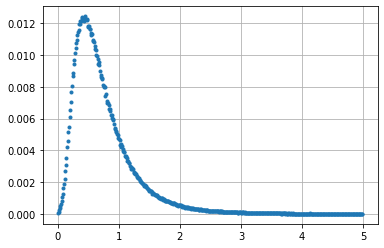

In [34]:
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

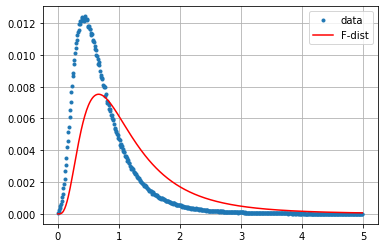

In [ ]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [ ]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

0.7559506009646411 1.25
0.41362454410324156 0.9375


In [35]:
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)